In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

RESULTADO_DIR = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado")
DATA_FILE = RESULTADO_DIR / "PASO_11_dataset_final" / "dataset_Xy_3dates_yield2025.csv"

TARGET = "yield_t_ha"   # o "yield_kgm2"

df = pd.read_csv(DATA_FILE)

drop_cols = {"plot_id", "obsUnitId", "yield_kgm2", "yield_t_ha"}
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].replace([np.inf, -np.inf], np.nan).copy()
y = df[TARGET].copy()

# winsorize 1%-99% para evitar outliers raros
for c in X.columns:
    lo, hi = X[c].quantile(0.01), X[c].quantile(0.99)
    X[c] = X[c].clip(lo, hi)

mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask].astype(np.float32)
y = y.loc[mask].astype(np.float32)

print("✅ X:", X.shape, " y:", y.shape)


✅ X: (202, 21)  y: (202,)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def eval_reg(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return {"model": name, "rmse": rmse, "mae": mae, "r2": r2, "pred": pred, "fitted": model}

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (161, 21) Test: (41, 21)


In [3]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

results = []

# 1) Random Forest (no necesita escalado)
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)
results.append(eval_reg("RandomForest", rf, X_train, y_train, X_test, y_test))

# 2) Gradient Boosting (rápido y fuerte)
hgb = HistGradientBoostingRegressor(
    random_state=42,
    max_depth=6,
    learning_rate=0.05,
    max_iter=600
)
results.append(eval_reg("HistGradientBoosting", hgb, X_train, y_train, X_test, y_test))

# 3) MLP (red neuronal simple) con escalado
mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        random_state=42,
        max_iter=2000,
        early_stopping=True
    ))
])
results.append(eval_reg("MLP", mlp, X_train, y_train, X_test, y_test))

summary = pd.DataFrame([{k:v for k,v in r.items() if k in ["model","rmse","mae","r2"]} for r in results]).sort_values("rmse")
summary


,model,rmse,mae,r2
2,MLP,34.778718,19.346292,0.294315
1,HistGradientBoosting,40.664443,26.396576,0.035254
0,RandomForest,50.777875,26.126051,-0.504293


✅ Mejor modelo: MLP
RMSE: 34.77871768914953 | MAE: 19.34629249572754 | R2: 0.2943154573440552


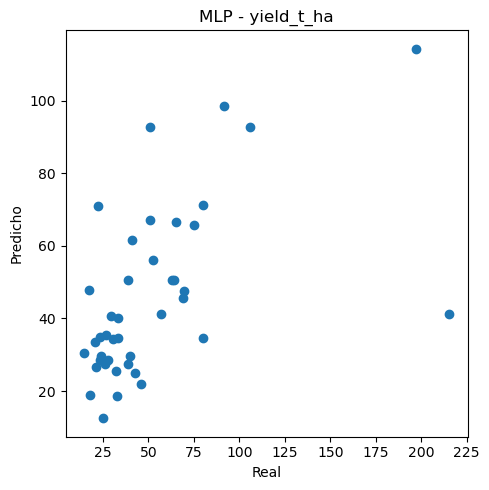

In [4]:
import matplotlib.pyplot as plt

best = sorted(results, key=lambda r: r["rmse"])[0]
print("✅ Mejor modelo:", best["model"])
print("RMSE:", best["rmse"], "| MAE:", best["mae"], "| R2:", best["r2"])

y_pred = best["pred"]

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title(f"{best['model']} - {TARGET}")
plt.tight_layout()
plt.show()


In [5]:
import joblib

OUT13 = RESULTADO_DIR / "PASO_13_Proposed_Model"
OUT13.mkdir(parents=True, exist_ok=True)

# guardar predicciones
pred_df = pd.DataFrame({"y_true": y_test.values, "y_pred": y_pred})
pred_path = OUT13 / f"{best['model']}_test_predictions_{TARGET}.csv"
pred_df.to_csv(pred_path, index=False)

# guardar modelo
model_path = OUT13 / f"{best['model']}_model_{TARGET}.joblib"
joblib.dump(best["fitted"], model_path)

print("✅ Guardado:", pred_path)
print("✅ Guardado:", model_path)

# importancia (si el modelo la soporta)
fitted = best["fitted"]
if hasattr(fitted, "feature_importances_"):
    imp = fitted.feature_importances_
    imp_df = pd.DataFrame({"feature": X.columns, "importance": imp}).sort_values("importance", ascending=False)
    imp_path = OUT13 / f"{best['model']}_feature_importance_{TARGET}.csv"
    imp_df.to_csv(imp_path, index=False)
    print("✅ Guardado:", imp_path)
    display(imp_df.head(15))
else:
    print("Este modelo no expone feature_importances_.")


✅ Guardado: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model\MLP_test_predictions_yield_t_ha.csv
✅ Guardado: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model\MLP_model_yield_t_ha.joblib
Este modelo no expone feature_importances_.


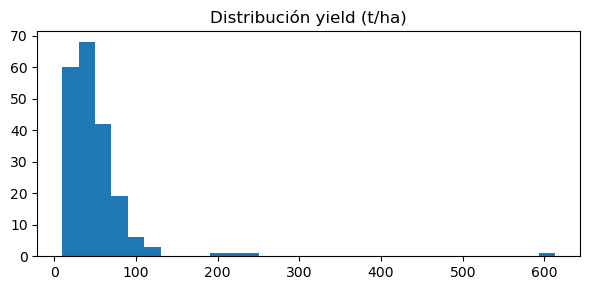

P95: 101.70750274658201  | P99: 215.28265960693375  | max: 613.3333129882812


In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,3))
plt.hist(y, bins=30)
plt.title("Distribución yield (t/ha)")
plt.tight_layout()
plt.show()

q95, q99 = np.quantile(y, [0.95, 0.99])
print("P95:", q95, " | P99:", q99, " | max:", float(np.max(y)))


✅ CV (5-fold) MLP con log(y)
RMSE: 102.92065929333624 | MAE: 40.671024322509766 | R2: -3.1803064346313477


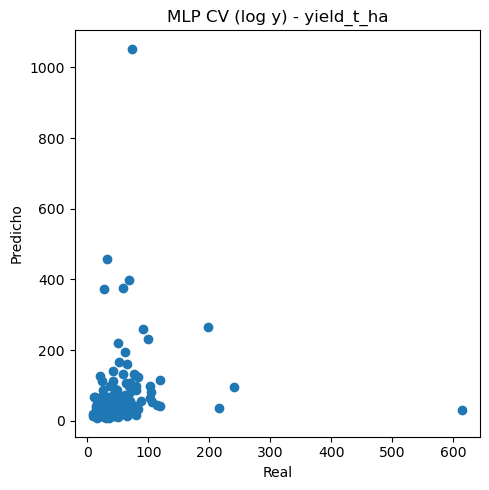

In [7]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# log1p para manejar yields altos
y_log = np.log1p(y)

mlp_log = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        random_state=42,
        max_iter=3000,
        early_stopping=True
    ))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)
pred_log = cross_val_predict(mlp_log, X, y_log, cv=cv)

# volver a escala original
pred = np.expm1(pred_log)

rmse = np.sqrt(mean_squared_error(y, pred))
mae  = mean_absolute_error(y, pred)
r2   = r2_score(y, pred)

print("✅ CV (5-fold) MLP con log(y)")
print("RMSE:", rmse, "| MAE:", mae, "| R2:", r2)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(y, pred)
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("MLP CV (log y) - yield_t_ha")
plt.tight_layout()
plt.show()


In [10]:
import numpy as np

p99 = np.quantile(y, 0.99)
p95 = np.quantile(y, 0.95)

y_cap = y.clip(upper=p99)

print("P95:", p95, "| P99:", p99, "| max:", float(y.max()))
print("Outliers > P99:", int((y > p99).sum()))


P95: 101.70750274658201 | P99: 215.28265960693375 | max: 613.3333129882812
Outliers > P99: 3


In [11]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "MLP": Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=(64,32), random_state=42, max_iter=3000, early_stopping=True))
    ]),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42, max_depth=6, learning_rate=0.05, max_iter=800),
    "RandomForest": RandomForestRegressor(n_estimators=800, random_state=42, n_jobs=-1, min_samples_leaf=2),
}

rows = []
preds = {}

for name, model in models.items():
    pred = cross_val_predict(model, X, y_cap, cv=cv)
    preds[name] = pred
    rows.append({
        "model": name,
        "rmse": float(np.sqrt(mean_squared_error(y_cap, pred))),
        "mae": float(mean_absolute_error(y_cap, pred)),
        "r2": float(r2_score(y_cap, pred)),
    })

summary_cv = pd.DataFrame(rows).sort_values("rmse")
summary_cv


,model,rmse,mae,r2
2,RandomForest,28.039211,17.322493,0.250866
0,MLP,28.959593,18.346247,0.200878
1,HistGradientBoosting,31.339396,20.196520,0.064143


✅ Mejor por CV con y_cap: RandomForest


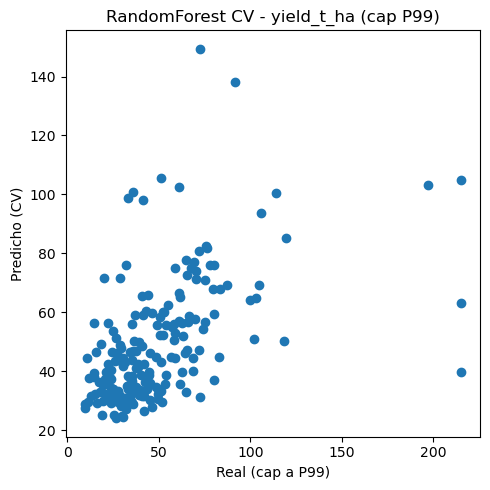

✅ Guardado: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model\RandomForest_CV_predictions_yield_t_ha_capP99.csv


In [12]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

best_name = summary_cv.iloc[0]["model"]
best_pred = preds[best_name]

print("✅ Mejor por CV con y_cap:", best_name)

plt.figure(figsize=(5,5))
plt.scatter(y_cap, best_pred)
plt.xlabel("Real (cap a P99)")
plt.ylabel("Predicho (CV)")
plt.title(f"{best_name} CV - yield_t_ha (cap P99)")
plt.tight_layout()
plt.show()

# Guardar
OUT = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model")
OUT.mkdir(parents=True, exist_ok=True)

pred_df = pd.DataFrame({"y_true_cap": y_cap, "y_pred_cv": best_pred})
out_path = OUT / f"{best_name}_CV_predictions_yield_t_ha_capP99.csv"
pred_df.to_csv(out_path, index=False)
print("✅ Guardado:", out_path)


In [13]:
from sklearn.ensemble import RandomForestRegressor
import joblib
import pandas as pd
import numpy as np
from pathlib import Path

RESULTADO_DIR = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado")
OUT13 = RESULTADO_DIR / "PASO_13_Proposed_Model"
OUT13.mkdir(parents=True, exist_ok=True)

# Entrenar final con TODOS los datos (y_cap)
rf_final = RandomForestRegressor(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)
rf_final.fit(X, y_cap)

# Guardar modelo
model_path = OUT13 / "RandomForest_model_yield_t_ha_capP99.joblib"
joblib.dump(rf_final, model_path)
print("✅ Modelo guardado:", model_path)

# Importancias
imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance": rf_final.feature_importances_
}).sort_values("importance", ascending=False)

imp_path = OUT13 / "RandomForest_feature_importance_yield_t_ha_capP99.csv"
imp_df.to_csv(imp_path, index=False)
print("✅ Importancias guardadas:", imp_path)

imp_df.head(20)


✅ Modelo guardado: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model\RandomForest_model_yield_t_ha_capP99.joblib
✅ Importancias guardadas: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model\RandomForest_feature_importance_yield_t_ha_capP99.csv


,feature,importance
18,VF_20251002,0.328279
12,SAVI2_mean_20251002,0.164957
2,CHLGR_mean_20251210,0.041446
19,VF_20251103,0.039797
13,SAVI2_mean_20251103,0.037280
10,OSAVI_mean_20251103,0.035073
8,NDVI_mean_20251210,0.033179
7,NDVI_mean_20251103,0.031712
20,VF_20251210,0.030294
3,MARI_mean_20251002,0.027259


In [14]:
import pandas as pd
from pathlib import Path

RESULTADO_DIR = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado")
DATA_FILE = RESULTADO_DIR / "PASO_11_dataset_final" / "dataset_Xy_3dates_yield2025.csv"
OUT13 = RESULTADO_DIR / "PASO_13_Proposed_Model"

df_full = pd.read_csv(DATA_FILE)

# Asegurar que el orden coincide con X/y (si en tu notebook filtraste filas con mask, usa el mismo mask)
df_out = df_full.loc[mask, ["plot_id", "obsUnitId"]].copy()
df_out["y_true_capP99"] = y_cap
df_out["y_pred_cv_capP99"] = preds["RandomForest"]

out_map = OUT13 / "RandomForest_CV_predictions_with_plotid_capP99.csv"
df_out.to_csv(out_map, index=False)
print("✅ Guardado:", out_map)

df_out.head()


✅ Guardado: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model\RandomForest_CV_predictions_with_plotid_capP99.csv


,plot_id,obsUnitId,y_true_capP99,y_pred_cv_capP99
0,1,1,32.866665,33.811929
1,2,2,49.362965,32.273416
2,3,3,29.933332,30.092347
3,4,4,23.794872,29.079050
4,5,5,41.644444,26.453390


In [15]:
import pandas as pd

# Pon aquí tus métricas PLSR si las anotaste; si no, déjalas como NaN
plsr_rmse = np.nan
plsr_r2   = np.nan

# RandomForest CV capP99 (tómalo de summary_cv)
rf_row = summary_cv[summary_cv["model"]=="RandomForest"].iloc[0]

summary_final = pd.DataFrame([
    {"model": "PLSR (test)", "rmse": plsr_rmse, "r2": plsr_r2, "note": "sin capP99 (si no lo recalculaste)"},
    {"model": "RandomForest (CV capP99)", "rmse": rf_row["rmse"], "r2": rf_row["r2"], "note": "proposed model"}
])

summary_path = OUT13 / "final_model_summary.csv"
summary_final.to_csv(summary_path, index=False)
print("✅ Guardado:", summary_path)

summary_final


✅ Guardado: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model\final_model_summary.csv


,model,rmse,r2,note
0,PLSR (test),NaN,NaN,sin capP99 (si no lo recalculaste)
1,RandomForest (CV capP99),28.039211,0.250866,proposed model


In [16]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error

RESULTADO_DIR = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado")
OUT13 = RESULTADO_DIR / "PASO_13_Proposed_Model"

# --- asume que ya tienes X y y_cap creados (de la celda 0 que te di) ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

max_comp = min(15, X.shape[1], X.shape[0]-1)

rows = []
preds_pls = {}

for n in range(1, max_comp + 1):
    pls = Pipeline([
        ("scaler", StandardScaler()),
        ("pls", PLSRegression(n_components=n))
    ])
    pred = cross_val_predict(pls, X, y_cap, cv=cv).ravel()
    rmse = float(np.sqrt(mean_squared_error(y_cap, pred)))
    r2 = float(r2_score(y_cap, pred))
    rows.append((n, rmse, r2))
    preds_pls[n] = pred

res_pls = pd.DataFrame(rows, columns=["n_components", "rmse", "r2"]).sort_values("rmse")
display(res_pls.head(10))

best_n = int(res_pls.iloc[0]["n_components"])
best_rmse = float(res_pls.iloc[0]["rmse"])
best_r2 = float(res_pls.iloc[0]["r2"])
print("✅ Mejor PLSR (CV capP99): n =", best_n, "| RMSE =", best_rmse, "| R2 =", best_r2)

# actualizar resumen final
summary_path = OUT13 / "final_model_summary.csv"
summary_final = pd.read_csv(summary_path)

summary_final.loc[summary_final["model"]=="PLSR (test)", ["rmse","r2","note"]] = [best_rmse, best_r2, f"CV capP99 (n={best_n})"]
summary_final.to_csv(summary_path, index=False)

print("✅ Resumen actualizado:", summary_path)
summary_final


,n_components,rmse,r2
8,9,29.460436,0.172998
14,15,29.517434,0.169795
10,11,29.518996,0.169707
7,8,29.606924,0.164753
9,10,29.607943,0.164696
13,14,29.618203,0.164117
11,12,29.625402,0.163710
12,13,29.650378,0.162300
6,7,29.851008,0.150925
5,6,30.118340,0.135649


✅ Mejor PLSR (CV capP99): n = 9 | RMSE = 29.460435777488712 | R2 = 0.17299803124326507
✅ Resumen actualizado: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model\final_model_summary.csv


,model,rmse,r2,note
0,PLSR (test),29.460436,0.172998,CV capP99 (n=9)
1,RandomForest (CV capP99),28.039211,0.250866,proposed model


In [17]:
import matplotlib.pyplot as plt
from pathlib import Path

OUT = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model")

# RF CV (ya lo tienes en preds["RandomForest"])
rf_pred = preds["RandomForest"]

plt.figure(figsize=(5,5))
plt.scatter(y_cap, rf_pred)
plt.xlabel("Real (cap P99)")
plt.ylabel("Predicho (CV)")
plt.title("RandomForest CV - yield_t_ha (cap P99)")
plt.tight_layout()
plt.savefig(OUT / "scatter_RF_CV_capP99.png", dpi=250)
plt.close()

# PLSR CV (mejor n=9): si guardaste pred_plsr = preds_pls[best_n]
plsr_pred = preds_pls[best_n]

plt.figure(figsize=(5,5))
plt.scatter(y_cap, plsr_pred)
plt.xlabel("Real (cap P99)")
plt.ylabel("Predicho (CV)")
plt.title(f"PLSR CV (n={best_n}) - yield_t_ha (cap P99)")
plt.tight_layout()
plt.savefig(OUT / "scatter_PLSR_CV_capP99.png", dpi=250)
plt.close()

print("✅ Figuras guardadas en:", OUT)


✅ Figuras guardadas en: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model


In [18]:
import pandas as pd
from pathlib import Path

OUT = Path(r"E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model")

summary = pd.read_csv(OUT / "final_model_summary.csv")
out_xlsx = OUT / "final_model_summary.xlsx"
summary.to_excel(out_xlsx, index=False)

print("✅ Guardado:", out_xlsx)
summary


✅ Guardado: E:\proyecto_agric_precision\Dataset de Imagenes\ortomosaicos_canales\resultado\PASO_13_Proposed_Model\final_model_summary.xlsx


,model,rmse,r2,note
0,PLSR (test),29.460436,0.172998,CV capP99 (n=9)
1,RandomForest (CV capP99),28.039211,0.250866,proposed model
